In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# CFPS2016

In [91]:
# 成人问卷
df1=pd.read_sas('CFPS2016/cfps2016adult_201906.sas7bdat')
df1['pid']=df1['pid'].astype(int)
# 家庭成员关系
# 需要从中识别父亲编号pid_f，再去成人问卷中匹配父亲pid
df2=pd.read_sas('CFPS2016/cfps2016famconf_201804.sas7bdat')
df2[['pid','pid_f']]=df2[['pid','pid_f']].astype(int)
# 家庭问卷
# df3=pd.read_sas('CFPS2016/cfps2016famecon_201807.sas7bdat')
# 2016跨年数据库:2016中好像没有需要用的数据
# df4=pd.read_sas('CFPS2016/cfps2016crossyearid_201807.sas7bdat')

In [92]:
# describe后发现id有为负数的，视作异常样本
# df1剔除id不在区间范围的记录
# 删除4条
out_df1=np.where((df1.pid<100051501)|(df1.pid>2489151502))[0]
df1.drop(out_df1,inplace=True)
df1.reset_index(drop=True,inplace=True)
# df2剔除pid_f等于-8和77的样本的记录
# 删除32844
out_df2=np.where((df2.pid<100051501)|(df2.pid>2845312554))[0] # 查看后没有记录
index1=np.where((df2.pid_f==-8)|(df2.pid_f==77))[0]
df2_1=df2.drop(list(out_df2)+list(index1))
df2_1.reset_index(drop=True,inplace=True)
# 筛选所需变量
df2_2=df2_1[['pid','pid_f','TB4_a16_p','TB4_a16_f']] # 添加了最高学历

# 进行从个人库中匹配子代的相关信息
# 成人库中选取相关变量
'''
pa301：现在的户口状况
school：上学状态
employ：当前工作状态
qn4001：是否党员
QG303CODE_ISEI：职业isei
QP201：健康状况
cfps2016eduy：受教育年限
cfps2016eduy_im：受教育年限插补
incomeb：主要工作收入
incomea：一般工作收入
income：总收入
'''
df1_1=df1[['pid','provcd16','urban16','CFPS_AGE','CFPS_GENDER','PA301',
          'SCHOOL','EMPLOY','QN4001','QP201','cfps2016eduy',
           'cfps2016eduy_im', 'cfps2016edu','INCOMEB','INCOMEA','INCOME','incomeb_imp']]
# 从家庭问卷库中筛选一些资产变量
# 注意房产的单位是万元
# df3_1=df3[['fid16','FR1','FR101','FS6V','FS8','FP510','durables_asset','finance_asset','nonhousing_debts',
#           'land_asset','resivalue']]

In [93]:
# 数据匹配，需要匹配两次，分别获取个人详细信息和父亲详细信息
# 获取个人信息
merge1=pd.merge(df1_1,df2_2,on='pid')
merge1.rename(columns={'pid_f':'fpid'},inplace=True)# 避免merge产生重复列
# 获取父亲信息
merge2=pd.merge(merge1,df1_1,left_on='fpid',right_on='pid',suffixes=['_p','_f'])
merge2.drop(['fpid'],axis=1,inplace=True)
# merge3=pd.merge(merge2,df3_1,left_on='fid16_p',right_on='fid16')
# 将列名全改为小写，方便后续操作
# 还是暂时用merge2吧
for x in merge2.columns.values:
    merge2.rename(columns={x:x.lower()},inplace=True)
merge2.head()#匹配了9317

,pid_p,provcd16_p,urban16_p,cfps_age_p,cfps_gender_p,pa301_p,school_p,employ_p,qn4001_p,qp201_p,...,employ_f,qn4001_f,qp201_f,cfps2016eduy_f,cfps2016eduy_im_f,cfps2016edu_f,incomeb_f,incomea_f,income_f,incomeb_imp_f
0,108660552,41.0,1.0,43.0,1.0,1.0,0.0,1.0,0.0,3.0,...,NaN,1.0,3.0,0.0,0.0,1.0,-8.0,NaN,-8.0,-8.0
1,109137501,41.0,1.0,31.0,1.0,3.0,0.0,1.0,0.0,3.0,...,1.0,0.0,3.0,12.0,12.0,4.0,-8.0,0.0,-8.0,39297.0
2,110003103,11.0,1.0,19.0,0.0,1.0,5.0,1.0,0.0,2.0,...,1.0,0.0,3.0,12.0,12.0,4.0,-8.0,0.0,-8.0,NaN
3,110006103,11.0,1.0,26.0,0.0,3.0,0.0,3.0,0.0,3.0,...,1.0,1.0,3.0,11.0,11.0,3.0,-8.0,0.0,-8.0,48290.0
4,110009107,11.0,1.0,28.0,1.0,3.0,0.0,1.0,0.0,3.0,...,3.0,0.0,5.0,NaN,6.0,1.0,-8.0,-8.0,-8.0,-8.0


In [94]:
len(merge2)

9557

In [95]:
# 筛选子辈年龄16-45,父辈年龄36-65,父子年龄差小于16(异常样本) 暂定这个范围
res1=merge2
index2=np.where((res1.cfps_age_p<16)|(res1.cfps_age_p>45))[0]
index3=np.where((res1.cfps_age_f<36)|(res1.cfps_age_f>65))[0]
# index2=np.where((res1.cfps_age_p<16))[0]
# index3=np.where((res1.cfps_age_f>65))[0]
res1['age_dif']=res1['cfps_age_f']-res1['cfps_age_p']
index4=np.where(res1['age_dif']<10)[0]
res2=res1.drop(list(index2)+list(index3)+list(index4))
# 剩余7862
res2.reset_index(drop=True,inplace=True)

In [96]:
len(res2)

7858

In [97]:
# 筛选已离开学校，且有工作的样本school=0,employ=1，不要在职学生的数据（数据量比较小，且收入误差可能较大）
# school employ
# 注意需要用& |,用and,or会报错,&的优先级比==高,
index5=np.where((res2.school_p==0) & (res2.employ_p==1))[0]
# 先不管当前工作状态，因为可能只是暂时失业
# index5=np.where(res2.school_p==0)[0]
res3=res2.loc[index5,:]
# 剩余4322
res3.reset_index(drop=True,inplace=True)

In [98]:
len(res3)

4322

In [99]:
# 由于操作不当，2014-2016两次调查间主要工作未发生变动的人群的主要工作数据未采集成功，通过模型进行了插补
# 如果主要工作收入incomeb=-8缺失，需要看是否有incomeb_imp
# 考虑使用总收入income，因为有些一般工作收入incomea>incomeb，需要全面考虑,income=incomea+incomeb
# 计算前先剔除incomea=-9（缺失）,incomea=-8时取0，income=incomeb
res3['incomeb_adj_p']=res3.apply(lambda x:x['incomeb_imp_p'] if x['incomeb_p']==-8 else x['incomeb_p'],axis=1)
res3['incomeb_adj_f']=res3.apply(lambda x:x['incomeb_imp_f'] if x['incomeb_f']==-8 else x['incomeb_f'],axis=1)
res3.drop(['incomeb_p','incomeb_f'],axis=1,inplace=True)
res3.rename(columns={'incomeb_adj_p':'incomeb_p','incomeb_adj_f':'incomeb_f'},inplace=True)
res3.reset_index(drop=True,inplace=True)
index6=np.where((res3.incomea_p==-9)|(res3.incomea_f==-9))[0]
res3.drop(index6,inplace=True)
res3.reset_index(drop=True,inplace=True)
res3['income_p']=res3.apply(lambda x:x['incomea_p']+x['incomeb_p'] if x['incomea_p']!=-8 else x['incomeb_p'],axis=1)
res3['income_f']=res3.apply(lambda x:x['incomea_f']+x['incomeb_f'] if x['incomea_f']!=-8 else x['incomeb_f'],axis=1)

In [100]:
# 剔除收入为空，或为-8,0的样本数据，以income为标准
res4=res3.dropna(subset=['income_p','income_f']).reset_index(drop=True) # 剔除缺失值
index7=np.where((res4['income_p'].isin([-8,0]))|(res4['income_f'].isin([-8,0])))[0] # 剔除收入不适用和为0的数据
res5=res4.drop(index7) # 剩1155
res5.reset_index(drop=True,inplace=True)

In [101]:
def eduy(x):
    if x==1:
        return 0
    elif x==2:
        return 6
    elif x==3:
        return 9
    elif x==4:
        return 12
    elif x==5:
        return 15
    elif x==6:
        return 16
    elif x==7:
        return 19
    elif x==8:
        return 22

In [102]:
# 查看学历是否需要插补
# 若教育年限缺失，看是否能用插补值；若最高学历缺失，考虑用最近一次调查的最高学历
# 注意插补后有为-8和空的，后续记得剔除
res6=res5.copy()
res6['cfps2016eduy_p']=res6.apply(lambda x:x['cfps2016eduy_im_p'] if np.isnan(x['cfps2016eduy_p']) else x['cfps2016eduy_p'],axis=1)
res6['cfps2016eduy_f']=res6.apply(lambda x:x['cfps2016eduy_im_f'] if np.isnan(x['cfps2016eduy_f']) else x['cfps2016eduy_f'],axis=1)
res6['cfps2016edu_p']=res6.apply(lambda x:x['tb4_a16_p'] if np.isnan(x['cfps2016edu_p']) else x['cfps2016edu_p'],axis=1)
res6['cfps2016edu_f']=res6.apply(lambda x:x['tb4_a16_f'] if np.isnan(x['cfps2016edu_f']) else x['cfps2016edu_f'],axis=1)
res6['cfps2016eduy_p']=res6.apply(lambda x:eduy(x['cfps2016edu_p']) if np.isnan(x['cfps2016eduy_p']) else x['cfps2016eduy_p'],axis=1)
res6['cfps2016eduy_f']=res6.apply(lambda x:eduy(x['cfps2016edu_f']) if np.isnan(x['cfps2016eduy_f']) else x['cfps2016eduy_f'],axis=1)
res6.drop(['cfps2016eduy_im_p','cfps2016eduy_im_f'],axis=1,inplace=True)

In [103]:
# # 计算收入的分位数
# 在剔除其他变量前计算分位数，避免样本选择带来误差
tmp_inp=np.array(res5['income_p'])
tmp_inf=np.array(res5['income_f'])
per_p=[np.percentile(tmp_inp,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
per_f=[np.percentile(tmp_inf,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
col_name=['100%max','99%','95%','90%','75%','50%','25%','10%','5%','1%','0%min']
pd.DataFrame([per_p,per_f],columns=col_name)

,100%max,99%,95%,90%,75%,50%,25%,10%,5%,1%,0%min
0,572000.0,208841.72,108479.2,77852.8,52700.0,35600.0,20000.0,8302.8,4044.8,1492.64,1.0
1,1040000.0,145449.24,74698.8,60000.0,41800.0,29760.0,18974.0,8782.4,5560.0,3000.00,700.0


In [50]:
# 剔除首尾1%的极端数据，61条
# index8=np.where((res5.income_p<=np.percentile(tmp_inp,1))|(res5.income_p>=np.percentile(tmp_inp,99))|
#                (res5.income_f<=np.percentile(tmp_inf,1))|(res5.income_f>=np.percentile(tmp_inf,99)))[0]
# res6=res5.drop(index8)# 剩1108
# res6.reset_index(drop=True,inplace=True)

In [104]:
# 根据其他相关变量剔除样本，包括缺失、不适用等
# 先不管家庭层面的变量，因为可能用不到
res7=res6.dropna(subset=['provcd16_p','provcd16_f','urban16_p','urban16_f','pa301_p','pa301_f',
                         'cfps_gender_p','cfps_gender_f','qn4001_p','qn4001_p','qp201_p','qp201_f',
                         'cfps2016eduy_p','cfps2016eduy_f','cfps2016edu_p','cfps2016edu_f']).reset_index(drop=True)
index9=np.where((res7.urban16_p==-9)|(res7.urban16_f==-9)|(res7.provcd16_p==-9)|(res7.provcd16_f==-9)|
            (res7.cfps_gender_p==-8)|(res7.cfps_gender_f==-8)|(res7.pa301_p.isin([-1,-2,5,79]))|
            (res7.pa301_f.isin([-1,-2,5,79]))|(res7.qn4001_p.isin([-1,-9]))|(res7.qn4001_f.isin([-1,-9]))|
            (res7.qp201_p.isin([-1,-9]))|(res7.qp201_f.isin([-1,-9])))[0]
res7.drop(index9,inplace=True)
res7.reset_index(drop=True,inplace=True)# 剩1117
res7['year']=2016

In [105]:
len(res7)

1073

In [106]:
# 计算收入阶层
def per_num(x,tmp):
    '''
    x:income
    tmp:array(income)
    '''
    if x<=np.percentile(tmp,20):
        return 1
    elif np.percentile(tmp,20)<x<=np.percentile(tmp,40):
        return 2
    elif np.percentile(tmp,40)<x<=np.percentile(tmp,60):
        return 3
    elif np.percentile(tmp,60)<x<=np.percentile(tmp,80):
        return 4
    else:
        return 5

res7['rank_p']=res7['income_p'].map(lambda x:per_num(x,tmp_inp))
res7['rank_f']=res7['income_f'].map(lambda x:per_num(x,tmp_inf))
# 收入阶层流动
res7['rank_flow']=res7.apply(lambda x:1 if x['rank_p']>x['rank_f'] else (-1 if x['rank_p']<x['rank_f'] else 0),axis=1)

In [107]:
res7.groupby('rank_p')['pid_p'].size()

rank_p
1    212
2    236
3    189
4    228
5    208
Name: pid_p, dtype: int64

In [78]:
res7.groupby('rank_f')['pid_f'].size()

rank_f
1    214
2    216
3    213
4    221
5    209
Name: pid_f, dtype: int64

In [57]:
res7.groupby('rank_flow').size()

rank_flow
-1    418
 0    234
 1    421
dtype: int64

In [58]:
res7.groupby('urban16_f').size()

urban16_f
0.0    443
1.0    630
dtype: int64

In [116]:
res7.columns.values.tolist()

['fid16_p',
 'pid_p',
 'provcd_p',
 'urban_p',
 'age_p',
 'gender_p',
 'hukou_p',
 'school_p',
 'employ_p',
 'party_p',
 'isei_p',
 'heal_p',
 'eduy_p',
 'edu_p',
 'income_p',
 'fid16_f',
 'pid_f',
 'provcd_f',
 'urban_f',
 'age_f',
 'gender_f',
 'hukou_f',
 'school_f',
 'employ_f',
 'party_f',
 'isei_f',
 'heal_f',
 'eduy_f',
 'edu_f',
 'income_f',
 'fid16',
 'fr1',
 'fr101',
 'fs6v',
 'fs8',
 'durables_asset',
 'finance_asset',
 'nonhousing_debts',
 'land_asset',
 'resivalue',
 'age_dif',
 'year',
 'rank_p',
 'rank_f',
 'rank_flow']

In [108]:
res7.drop(['incomea_p','incomea_f','incomeb_p','incomeb_f','incomeb_imp_p','incomeb_imp_f','tb4_a16_p','tb4_a16_f'],axis=1,inplace=True)

In [109]:
res7.rename(columns={'provcd16_p':'provcd_p','provcd16_f':'provcd_f','urban16_p':'urban_p','urban16_f':'urban_f','cfps_age_p':'age_p',
                    'cfps_age_f':'age_f','cfps_gender_p':'gender_p','cfps_gender_f':'gender_f','pa301_p':'hukou_p','pa301_f':'hukou_f',
                    'qg101_p':'job_p','qg101_f':'job_f','cfps2016edu_p':'edu_p','cfps2016edu_f':'edu_f','cfpsedu2016_p':'edu_p','cfpsedu2016_f':'edu_f',
                    'qn4001_p':'party_p','qn4001_f':'party_f','qp201_p':'heal_p','qp201_f':'heal_f','cfps2016eduy_p':'eduy_p','cfps2016eduy_f':'eduy_f'},inplace=True)

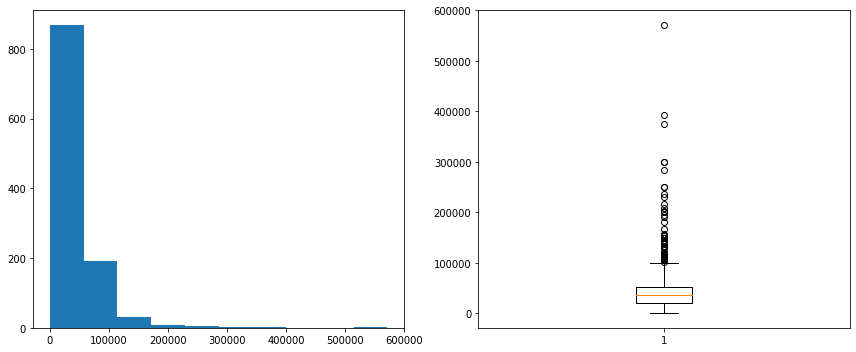

In [110]:
# 子代收入分布情况
fig_p = plt.figure(figsize=(12,5))
ax1_p = fig_p.add_subplot(121)
ax2_p=fig_p.add_subplot(122)
ax1_p.hist(res5['income_p'],bins=10)
ax2_p.boxplot(res5['income_p'])
fig_p.tight_layout()
plt.show()

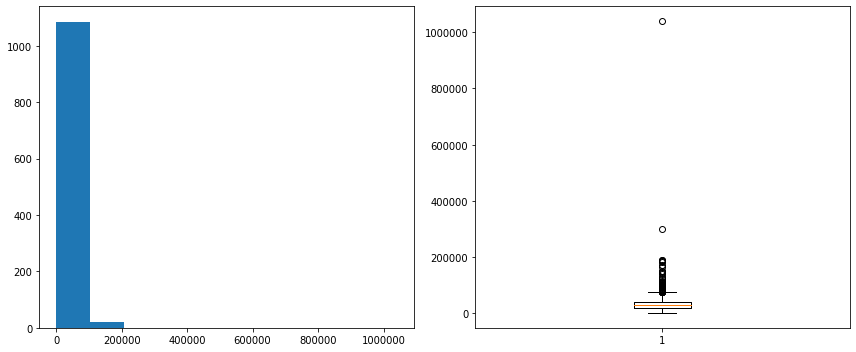

In [61]:
# 父代收入分布情况
fig_f = plt.figure(figsize=(12,5))
ax1_f = fig_f.add_subplot(121)
ax2_f=fig_f.add_subplot(122)
ax1_f.hist(res5['income_f'],bins=10)
ax2_f.boxplot(res5['income_f'])
fig_f.tight_layout()
plt.show()

In [111]:
res7[['hukou_p','hukou_f']]=res7[['hukou_p','hukou_f']].apply(lambda x:x.replace(3,0))
res7['rank_dif']=res7['rank_p']-res7['rank_f']

In [112]:
# 注意索引和列，不再是从0开始，而是直接对应索引和列的值,如果从0开始记得用iloc
a=res7[res7.hukou_p==1].groupby(['rank_f','rank_p']).size().unstack()
a

rank_p,1,2,3,4,5
rank_f,,,,,
1,37,39,25,31,21
2,25,41,33,34,17
3,30,33,25,27,26
4,31,33,23,19,24
5,28,27,18,28,19


In [27]:
total=a.sum().sum()# 总和
sum_p=a.sum(axis=0)# 列求和
sum_f=a.sum(axis=1)# 行求和

In [28]:
# 流动性指数、继承性指数
m=pd.DataFrame(np.zeros((5,5)))
# i父亲，j子代
for i in range(5):
    for j in range(5):
        m.iloc[i,j]=a.iloc[i,j]*total/(sum_p.iloc[j]*sum_f.iloc[i])
m.index=range(1,6)
m.columns=range(1,6)
m

,1,2,3,4,5
1,1.111457,1.022555,0.914506,1.011614,0.890233
2,0.766004,1.096493,1.231290,1.131703,0.735078
3,0.977878,0.938876,0.992336,0.956069,1.195997
4,1.095976,1.018319,0.990199,0.729718,1.197412
5,1.072406,0.902601,0.839516,1.164988,1.026947


In [29]:
# 流出指数index_out，流入指数index_in
b=pd.DataFrame(np.zeros((5,2)),columns=['index_out','index_in'],index=range(1,6))
for i in b.index:
    b.loc[i,'index_out']=(sum_f[i]-a[i][i])/(len(b)-1)
    b.loc[i,'index_in']=(sum_p[i]-a[i][i])/(len(b)-1)  
b

,index_out,index_in
1,29.00,28.50
2,27.25,33.00
3,29.00,24.75
4,27.75,30.00
5,25.25,22.00


In [113]:
p_city_pro=pd.read_csv('data result/p_city_pro.csv',encoding='GBK',index_col=0).reset_index()
expend_farm_pro=pd.read_csv('data result/expend_farm_pro.csv',encoding='GBK',index_col=0).reset_index()
expend_edu_pro=pd.read_csv('data result/expend_edu_pro.csv',encoding='GBK',index_col=0).reset_index()
exp_GDP_pro=pd.read_csv('data result/exp_GDP_pro.csv',encoding='GBK',index_col=0).reset_index()
province=pd.read_csv('data result/province.csv',encoding='GBK')
birth_rate=pd.read_csv('data result/birth_rate.csv',encoding='GBK',index_col=0).reset_index()
cpi=pd.read_csv('data result/各省CPI_2010基期.csv',encoding='GBK',index_col=0).reset_index()
pGDP=pd.read_csv('data result/各省人均GDP.csv',encoding='GBK',index_col=0).reset_index()

In [114]:
p_city_pro=province.merge(p_city_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
expend_edu_pro=province.merge(expend_edu_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
expend_farm_pro=province.merge(expend_farm_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
exp_GDP_pro=province.merge(exp_GDP_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
birth_rate=province.merge(birth_rate,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
cpi=province.merge(cpi,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
pGDP=province.merge(pGDP,left_on='Label',right_on='index').drop(['Label','index'],axis=1)

In [115]:
# 将人均GDP调整到2010年的不变价格
col=['2010','2011','2012','2013','2014','2015','2016']
for i in col:
    pGDP[i]=pGDP[i]/cpi[i]

In [116]:
res7=res7.merge(p_city_pro[['No','2016']],left_on='provcd_p',right_on='No').rename(columns={'2016':'p_city_pro'}).drop('No',axis=1)
res7=res7.merge(expend_farm_pro[['No','2016']],left_on='provcd_p',right_on='No').rename(columns={'2016':'expend_farm_pro'}).drop('No',axis=1)
res7=res7.merge(expend_edu_pro[['No','2016']],left_on='provcd_p',right_on='No').rename(columns={'2016':'expend_edu_pro'}).drop('No',axis=1)
res7=res7.merge(exp_GDP_pro[['No','2016']],left_on='provcd_p',right_on='No').rename(columns={'2016':'exp_GDP_pro'}).drop('No',axis=1)
res7=res7.merge(birth_rate[['No','2016']],left_on='provcd_p',right_on='No').rename(columns={'2016':'birth_rate'}).drop('No',axis=1)
res7=res7.merge(pGDP[['No','2016']],left_on='provcd_p',right_on='No').rename(columns={'2016':'pGDP'}).drop('No',axis=1)
res7=res7.merge(cpi[['No','2016']],left_on='provcd_p',right_on='No').rename(columns={'2016':'cpi'}).drop('No',axis=1)

In [117]:
# 2010年为基期，调整为不变价格
res7[['income_p','income_f']]=res7.apply(lambda x:x[['income_p','income_f']]/x['cpi'],axis=1)

In [118]:
res7.to_csv('data result/model2016.csv',index=False)